Uses NS-DMD on LFP data

In [1]:
species = 'nhp'
exp = 'WCST'

In [2]:
import plotly.express as px
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd
import scipy.stats
import scipy.signal as ss
from lfp_tools import general
from lfp_tools import startup_local as startup
from lfp_tools import development
from lfp_tools import analysis
import os

from nsdmd import nsdmd
from nsdmd import utils
from nsdmd import optdmd

In [3]:
subjects = startup.get_subjects(species, exp)
subject = subjects[0]

sessions = startup.get_session_ids(species, subject, exp)

In [4]:
import os
from stl import mesh

def plotly_add_glass_brain(fig1, subject, areas=['brain'], show_axis=False):
    '''
    Adds a glass brain to a plotly figure
    Code for rendering stl file is from here:
    https://chart-studio.plotly.com/~empet/15276/converting-a-stl-mesh-to-plotly-gomes/#/
    
    Parameters
    ----------------
    fig1 : plotly figure
    subject : subject of whom's glass brain to plot
    areas : list of strings indicating areas to print. List must limited to
        'brain', 'fef', 'dlpfc', 'mpfc', 'hippocampus'
        Use areas='all' if you want to plot all areas
    show_axis : whether or not to include axis
    '''
    def stl2mesh3d(stl_mesh):
        # stl_mesh is read by nympy-stl from a stl file; it is  an array of faces/triangles 
        # (i.e. three 3d points) 
        # this function extracts the unique vertices and the lists I, J, K to define a Plotly mesh3d
        p, q, r = stl_mesh.vectors.shape #(p, 3, 3)
        # the array stl_mesh.vectors.reshape(p*q, r) can contain multiple copies of the same vertex;
        # extract unique vertices from all mesh triangles
        vertices, ixr = np.unique(stl_mesh.vectors.reshape(p*q, r), return_inverse=True, axis=0)
        I = np.take(ixr, [3*k for k in range(p)])
        J = np.take(ixr, [3*k+1 for k in range(p)])
        K = np.take(ixr, [3*k+2 for k in range(p)])
        return vertices, I, J, K
    
    fig_data = fig1.data
    
    if areas=='all':
        areas = ['brain', 'fef', 'dlpfc', 'mpfc', 'hippocampus']
    
    for area in areas:
        if area=='brain':
            filename = 'glass brain.stl'
            colorscale= [[0, 'whitesmoke'], [1, 'whitesmoke']]
        elif area=='fef':
            filename = 'FEF.stl'
            colorscale= [[0, 'darkblue'], [1, 'darkblue']]
        elif area=='dlpfc':
            filename = 'dlPFC.stl'
            colorscale= [[0, 'lightgreen'], [1, 'lightgreen']]
        elif area=='mpfc':
            filename = 'mPFC.stl'
            colorscale= [[0, 'darkgreen'], [1, 'darkgreen']]
        elif area=='hippocampus':
            filename = 'Hippocampal.stl'
            colorscale= [[0, 'coral'], [1, 'coral']]
            
        stl_file = '/nas_data/rawdata/sub-'+subject+'/anatomy/'+filename
        
        if not os.path.isfile(stl_file):
            print(stl_file + ' does not exist, not including...')
            continue
    
        my_mesh = mesh.Mesh.from_file(stl_file)
    
        vertices, I, J, K = stl2mesh3d(my_mesh)
        x, y, z = vertices.T
    
        mesh3D = go.Mesh3d(x=x, y=y, z=z, i=I, j=J, k=K, \
                           opacity=0.14, colorscale=colorscale, intensity=z, showscale=False, name=area)
    
        layout = go.Layout(
            scene_xaxis_visible=False, 
            scene_yaxis_visible=False,
            scene_zaxis_visible=False,
            showlegend=True
        )
    
        fig2 = go.Figure(
            data=[mesh3D], 
            layout=layout
        )
        fig_data = fig_data + fig2.data
        
    fig3 = go.Figure(data=fig_data, layout=fig1.layout)
    if not show_axis:
        fig3.update_layout(layout)
    
    return(fig3)

In [5]:
session = sessions[26]
cl = startup.get_electrode_locations(species, subject, exp, session)

In [6]:
session

'20180918'

In [7]:
df = startup.get_behavior(species, subject, exp, session, import_obj_features=False)
df_sub = df[
    (df['response'].isin([200,206])) & \
    (df['badGroup']==0) & \
    (df['ignore']==0) & \
    (df['badTrials']==0) & \
    (df['group']>1) & \
    (df['group']<np.max(df.group.values))
]

In [8]:
files = startup.get_raw_filenames(species, subject, exp, session)
print(len(files))

203


# NS-DMD on a single, full trial

In [10]:
begin_offset = -500
end_offset = 500

t_cross_on = df_sub[(df_sub['act']=='cross_on')].time.values[0]
t_cross_fix = df_sub[(df_sub['act']=='cross_fix')].time.values[0]
t_cross_off = df_sub[(df_sub['act']=='cross_off')].time.values[0]
t_obj_fix = df_sub[(df_sub['act']=='obj_fix')].time.values[0]
t_end_fix = df_sub[(df_sub['act']=='fb')].time.values[0]
t_next_cross_on = df_sub[(df_sub['act']=='fb')].time.values[0] + 1900

print(t_next_cross_on - t_cross_on)

4601


In [11]:
data = np.empty((len(files), t_next_cross_on-t_cross_on-begin_offset+end_offset))

for i,f in enumerate(files):
    print(i,'/',len(files))
    sig = scipy.stats.zscore(general.open_local_h5py_file(f))
    data[i] = sig[t_cross_on+begin_offset:t_next_cross_on+end_offset]

print(data.shape)

0 / 203
1 / 203
2 / 203
3 / 203
4 / 203
5 / 203
6 / 203
7 / 203
8 / 203
9 / 203
10 / 203
11 / 203
12 / 203
13 / 203
14 / 203
15 / 203
16 / 203
17 / 203
18 / 203
19 / 203
20 / 203
21 / 203
22 / 203
23 / 203
24 / 203
25 / 203
26 / 203
27 / 203
28 / 203
29 / 203
30 / 203
31 / 203
32 / 203
33 / 203
34 / 203
35 / 203
36 / 203
37 / 203
38 / 203
39 / 203
40 / 203
41 / 203
42 / 203
43 / 203
44 / 203
45 / 203
46 / 203
47 / 203
48 / 203
49 / 203
50 / 203
51 / 203
52 / 203
53 / 203
54 / 203
55 / 203
56 / 203
57 / 203
58 / 203
59 / 203
60 / 203
61 / 203
62 / 203
63 / 203
64 / 203
65 / 203
66 / 203
67 / 203
68 / 203
69 / 203
70 / 203
71 / 203
72 / 203
73 / 203
74 / 203
75 / 203
76 / 203
77 / 203
78 / 203
79 / 203
80 / 203
81 / 203
82 / 203
83 / 203
84 / 203
85 / 203
86 / 203
87 / 203
88 / 203
89 / 203
90 / 203
91 / 203
92 / 203
93 / 203
94 / 203
95 / 203
96 / 203
97 / 203
98 / 203
99 / 203
100 / 203
101 / 203
102 / 203
103 / 203
104 / 203
105 / 203
106 / 203
107 / 203
108 / 203
109 / 203
110 / 203


In [23]:
bp_ranges = [[i,i+5] for i in np.arange(1,40,5)]
guesses = np.array([[bp[0]+1, -(bp[0]+1), bp[0]+3, -(bp[0]+3)] for bp in bp_ranges])
model = nsdmd.NSDMD(opt_rank=4, opt_stride=100, sim_thresh_phi_amp=0.9, sim_thresh_freq=0.5, sim_group_size=3, \
                    verbose=True, sim_thresh_phi_phase=10,\
                    bandpass = bp_ranges, bandpass_trim=500, feature_seq_method='SBS', feature_final_num=1000,\
                    feature_f_method='grad', feature_init=None, drift_flag=True, \
                    grad_alpha=0, grad_beta=2, grad_lr=0.01, grad_N=30, grad_maxiter=100)

sr = 1000

x = scipy.stats.zscore(data.copy(), axis=1)
t = (np.arange(x.shape[1]) + begin_offset) / sr

model.fit(x, t, sr)

t_len_final = len(t[model.bandpass_trim:model.bandpass_trim+model.windows_[-1,0]+model.opt_win])
freq, phi = model.get_freq_and_phi(
    t_len_final, 
    sr
)

idx = model.f_hat_ > np.mean(model.f_hat_, axis=1)[:,None]

freq_mean = np.array([np.mean(freq[j][idx[j]]) for j in range(len(idx)) if np.any(idx[j])])
phi_a_mean = np.array([np.mean(np.abs(phi[j][idx[j]]), axis=0) for j in range(len(idx)) if np.any(idx[j])])
phi_p_mean = np.array([scipy.stats.circmean(np.angle(phi[j][idx[j]]), axis=0, low=-np.pi, high=np.pi) for j in range(len(idx)) if np.any(idx[j])])
f_hat = np.array([model.f_hat_[j] for j in range(len(idx)) if np.any(idx[j])])

Starting OPT-DMD...
Starting bandpass freq: 1 - 6 Hz
Starting bandpass freq: 6 - 11 Hz
Starting bandpass freq: 11 - 16 Hz
Starting bandpass freq: 16 - 21 Hz
Starting bandpass freq: 21 - 26 Hz
Starting bandpass freq: 26 - 31 Hz
Starting bandpass freq: 31 - 36 Hz
Starting bandpass freq: 36 - 41 Hz
Gathering modes...
Found 83 modes
Number of modes: 83/83, stopping at 82
Guessing 83 number of modes


In [31]:
sr = 1000
task_events = ['Cross On', 'Cross Fix', 'End Required Fix', 'Search Begin', 'Object Fix', 'FB Start', 'Next Trial Cross']
task_timings = [t_cross_on, t_cross_fix, t_cross_fix+350, t_cross_off, t_obj_fix, t_end_fix+98, t_next_cross_on]
#FB begins 98 ms after end of object fixation
task_timings = (np.array(task_timings) - t_cross_on) / sr

x_extent = (np.arange(f_hat.shape[1])) / sr

In [47]:
plt.rcParams.update({'font.size': 16})

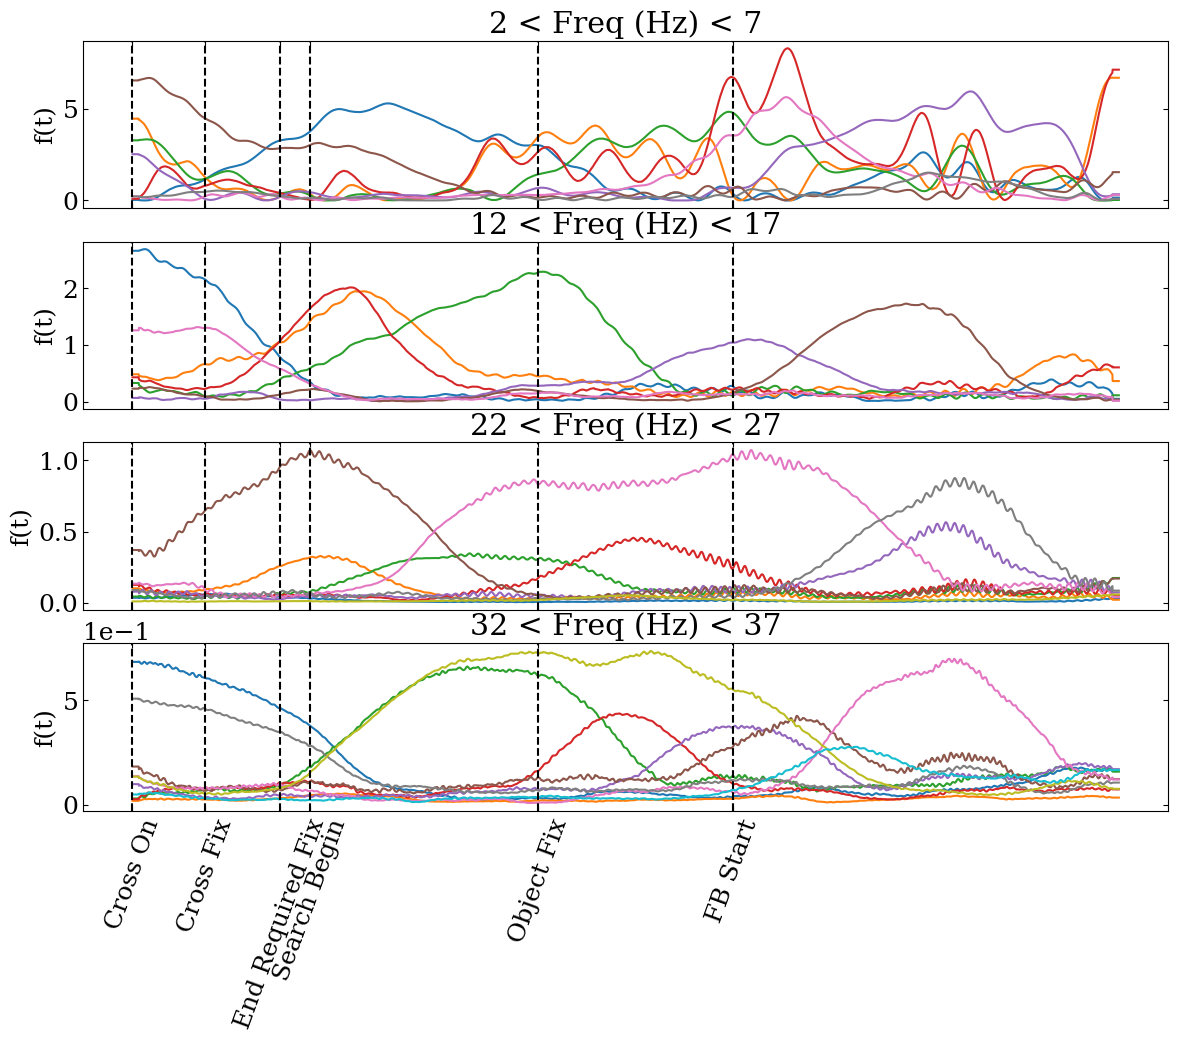

In [68]:
plt.rc('font', family='serif')

fig, ax = plt.subplots(4,1,figsize=(14,10), sharex=True)
for i in range(4):
    ax[i].tick_params(axis='both',which='both',direction='in',right=True,top=True)

for j in range(4):
    idx = (freq_mean>2+10*j) & (freq_mean<2+5+10*j)
    for i,f in enumerate(f_hat[idx][:10]):
        ax[j].plot(x_extent, f)
        ax[j].set_ylabel('f(t)')

for i in range(4):
    ax[i].set_title(str(2+10*i)+' < Freq (Hz) < '+str(2+5+10*i))
    ax[i].ticklabel_format(axis='y', style='sci', scilimits=[0,0])
    for line in task_timings[:-1]:
        ax[i].axvline(line, color='black', linestyle='dashed')

ax[-1].set_xticks(task_timings[:-1])
_ = ax[-1].set_xticklabels(task_events[:-1], rotation=70)

In [70]:
j = 3
mode_idx = 4
idx = (freq_mean>2+10*j) & (freq_mean<2+5+10*j)

xyz = pd.DataFrame()
xyz['x'] = cl.x.values
xyz['y'] = cl.y.values
xyz['z'] = cl.z.values
xyz['amp'] = phi_a_mean[idx][mode_idx]

temp = phi_p_mean[idx][mode_idx] - scipy.stats.circmean(phi_p_mean[idx][mode_idx], low=-np.pi, high=np.pi)
temp = (temp + np.pi) % (2*np.pi) - np.pi
xyz['phase'] = temp

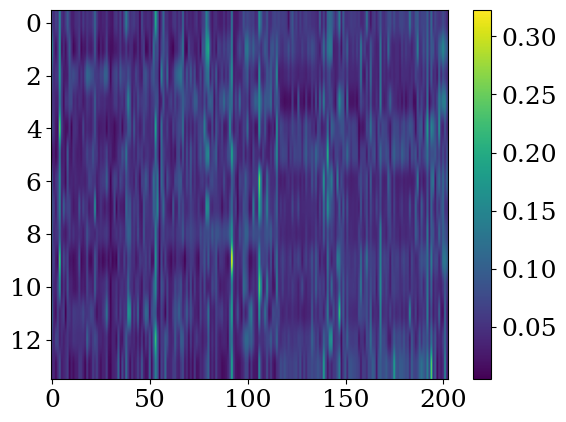

In [71]:
plt.imshow(phi_a_mean[idx], aspect='auto')
plt.colorbar()

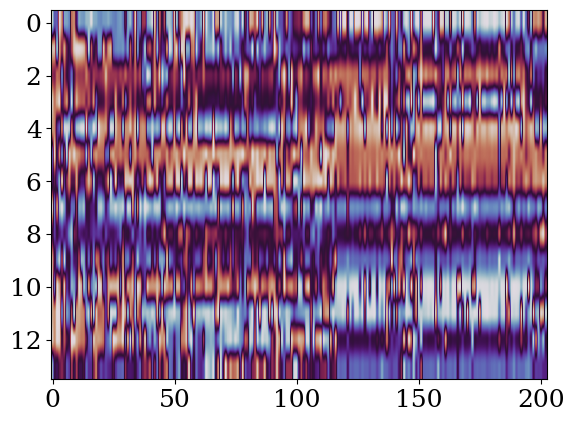

In [72]:
plt.imshow(phi_p_mean[idx], aspect='auto', cmap='twilight')

In [76]:
# Fot plotting in the brain, commented out for minimal file size

# color_fraction = 0.5

# fig1 = px.scatter_3d(
#     xyz, 
#     x='x',
#     y='y',
#     z='z', 
#     # color='amp',
#     # range_color=[0,0.15]
#     range_color=[-np.pi,np.pi],
#     color='phase',
#     color_continuous_scale='twilight'
# )

# fig = plotly_add_glass_brain(fig1, subject, areas='all', show_axis=False)
# temp_grid = dict(
#     showgrid=False, 
#     zeroline=False, 
#     showticklabels=False
# )
# camera = dict(
#     up=dict(x=0, y=-1, z=0),
#     center=dict(x=0, y=0, z=0),
#     eye=dict(x=1.1, y=0, z=0.7)
# )
# fig.update_layout(
#     autosize=False,
#     width=700,
#     height=600,
#     xaxis=temp_grid,
#     yaxis=temp_grid,
#     paper_bgcolor='rgba(0,0,0,0)',
#     plot_bgcolor='rgba(0,0,0,0)',
#     showlegend=True,
#     scene_camera=camera,
#     coloraxis_showscale=False
# )
# fig.show()

# NS-DMD on all trials only during feedback region

In [9]:
begin_offset = -1000
end_offset = 1000

t_fb = df_sub[(df_sub['act']=='fb')].time.values
res = df_sub[(df_sub['act']=='fb')].response.values

print(t_fb.shape)
print(res.shape)

(896,)
(896,)


In [10]:
data = np.empty((len(t_fb), len(files), 1500+2000))

for i,f in enumerate(files):
    print(i,'/',len(files))
    #1
    # sig = general.open_local_h5py_file(f)
    #2
    sig = scipy.stats.zscore(general.open_local_h5py_file(f))
    for j in range(len(t_fb)):
        #1,2
        data[j,i] = sig[t_fb[j]+begin_offset:t_fb[j]+1500+end_offset]

print(data.shape)

0 / 203
1 / 203
2 / 203
3 / 203
4 / 203
5 / 203
6 / 203
7 / 203
8 / 203
9 / 203
10 / 203
11 / 203
12 / 203
13 / 203
14 / 203
15 / 203
16 / 203
17 / 203
18 / 203
19 / 203
20 / 203
21 / 203
22 / 203
23 / 203
24 / 203
25 / 203
26 / 203
27 / 203
28 / 203
29 / 203
30 / 203
31 / 203
32 / 203
33 / 203
34 / 203
35 / 203
36 / 203
37 / 203
38 / 203
39 / 203
40 / 203
41 / 203
42 / 203
43 / 203
44 / 203
45 / 203
46 / 203
47 / 203
48 / 203
49 / 203
50 / 203
51 / 203
52 / 203
53 / 203
54 / 203
55 / 203
56 / 203
57 / 203
58 / 203
59 / 203
60 / 203
61 / 203
62 / 203
63 / 203
64 / 203
65 / 203
66 / 203
67 / 203
68 / 203
69 / 203
70 / 203
71 / 203
72 / 203
73 / 203
74 / 203
75 / 203
76 / 203
77 / 203
78 / 203
79 / 203
80 / 203
81 / 203
82 / 203
83 / 203
84 / 203
85 / 203
86 / 203
87 / 203
88 / 203
89 / 203
90 / 203
91 / 203
92 / 203
93 / 203
94 / 203
95 / 203
96 / 203
97 / 203
98 / 203
99 / 203
100 / 203
101 / 203
102 / 203
103 / 203
104 / 203
105 / 203
106 / 203
107 / 203
108 / 203
109 / 203
110 / 203


In [11]:
data.shape

(896, 203, 3500)

In [12]:
bp_ranges = [[i,i+5] for i in np.arange(1,40,5)]
guesses = np.array([[bp[0]+1, -(bp[0]+1), bp[0]+3, -(bp[0]+3)] for bp in bp_ranges])
model = nsdmd.NSDMD(opt_rank=4, opt_stride=100, sim_thresh_phi_amp=0.9, sim_thresh_freq=0.5, sim_group_size=3, \
                    verbose=True, sim_thresh_phi_phase=10,\
                    bandpass = bp_ranges, bandpass_trim=500, feature_seq_method='SBS', feature_final_num=1000,\
                    feature_f_method='grad', feature_init=None, drift_flag=True, \
                    grad_alpha=0, grad_beta=2, grad_lr=0.01, grad_N=30, grad_maxiter=100)

sr = 1000

for i in range(0,len(data)):
    print(i+1, '/', len(data))
    x = data[i].copy()
    t = (np.arange(x.shape[1]) + begin_offset) / sr

    model.fit(x, t, sr)

    t_len_final = len(t[model.bandpass_trim:model.bandpass_trim+model.windows_[-1,0]+model.opt_win])
    freq, phi = model.get_freq_and_phi(
        t_len_final, 
        sr
    )

    idx = model.f_hat_ > np.mean(model.f_hat_, axis=1)[:,None]

    freq_mean = np.array([np.mean(freq[j][idx[j]]) for j in range(len(idx)) if np.any(idx[j])])
    phi_a_mean = np.array([np.mean(np.abs(phi[j][idx[j]]), axis=0) for j in range(len(idx)) if np.any(idx[j])])
    phi_p_mean = np.array([scipy.stats.circmean(np.angle(phi[j][idx[j]]), axis=0, low=-np.pi, high=np.pi) for j in range(len(idx)) if np.any(idx[j])])
    f_hat = np.array([model.f_hat_[j] for j in range(len(idx)) if np.any(idx[j])])

    assert len(freq_mean)==len(phi_a_mean)
    assert len(freq_mean)==len(phi_p_mean)
    assert len(freq_mean)==len(f_hat)

    np.save('/nas_data/john_scratch/nsdmd_lfp/idx2_'+str(i)+'_freq.npy', freq_mean)
    np.save('/nas_data/john_scratch/nsdmd_lfp/idx2_'+str(i)+'_phi_a_mean.npy', phi_a_mean)
    np.save('/nas_data/john_scratch/nsdmd_lfp/idx2_'+str(i)+'_phi_p_mean.npy', phi_p_mean)
    np.save('/nas_data/john_scratch/nsdmd_lfp/idx2_'+str(i)+'_f_hat.npy', f_hat[:,500:-500])

    test = phi[np.any(idx, axis=1)][(freq_mean>2) & (freq_mean<4)]
    test2 = freq[np.any(idx, axis=1)][(freq_mean>2) & (freq_mean<4)]
    freqs_in = np.insert(test2[:,:-1], 0, np.zeros(len(test2)), axis=1)
    phase_in = np.cumsum(freqs_in / 1000, axis=1)
    temp = np.exp(2 * np.pi * 1j * phase_in)
    soln = np.transpose(np.angle((test * temp[:, :, None])[:,::100]), [0, 2, 1])

    np.save('/nas_data/john_scratch/nsdmd_lfp/idx2_'+str(i)+'_phi_p24.npy', soln[:,:,5:-5])

1 / 896
Starting OPT-DMD...
Starting bandpass freq: 1 - 6 Hz
Starting bandpass freq: 6 - 11 Hz
Starting bandpass freq: 11 - 16 Hz
Starting bandpass freq: 16 - 21 Hz
Starting bandpass freq: 21 - 26 Hz
Starting bandpass freq: 26 - 31 Hz
Starting bandpass freq: 31 - 36 Hz
Starting bandpass freq: 36 - 41 Hz
Gathering modes...
Found 42 modes
Number of modes: 42/42, stopping at 41
Guessing 42 number of modes
2 / 896
Starting OPT-DMD...
Starting bandpass freq: 1 - 6 Hz
Starting bandpass freq: 6 - 11 Hz
Starting bandpass freq: 11 - 16 Hz
Starting bandpass freq: 16 - 21 Hz
Starting bandpass freq: 21 - 26 Hz
Starting bandpass freq: 26 - 31 Hz
Starting bandpass freq: 31 - 36 Hz
Starting bandpass freq: 36 - 41 Hz
Gathering modes...
Found 43 modes
Number of modes: 43/43, stopping at 42
Guessing 43 number of modes
3 / 896
Starting OPT-DMD...
Starting bandpass freq: 1 - 6 Hz
Starting bandpass freq: 6 - 11 Hz
Starting bandpass freq: 11 - 16 Hz
Starting bandpass freq: 16 - 21 Hz
Starting bandpass freq:

### Load all modes

In [10]:
freq = []
phi_a = []
phi_p = []
phi_a_single = []
phi_p_single = []
f_hat = []
for i in range(896):
    freq.append(np.load('/nas_data/john_scratch/nsdmd_lfp/idx2_'+str(i)+'_freq.npy'))
    phi_a.append(np.load('/nas_data/john_scratch/nsdmd_lfp/idx2_'+str(i)+'_phi_a_mean.npy'))
    phi_p.append(np.load('/nas_data/john_scratch/nsdmd_lfp/idx2_'+str(i)+'_phi_p_mean.npy'))
    phi_p_single.append(np.load('/nas_data/john_scratch/nsdmd_lfp/idx2_'+str(i)+'_phi_p24.npy'))
    temp = np.load('/nas_data/john_scratch/nsdmd_lfp/idx2_'+str(i)+'_f_hat.npy')
    idx = np.any(temp > np.mean(temp, axis=1)[:,None], axis=1)
    f_hat.append(temp[idx])

In [11]:
sr = 1000
task_events = ['Cross On', 'Cross Fix', 'End Required Fix', 'Search Begin', 'Object Fix', 'FB Start', 'Next Trial Cross']

x_extent = (np.arange(f_hat[0].shape[1])) / sr

### Cluster all modes into correct/incorrect clusters between 19-21 Hz during feedback region

In [12]:
phi_a_cor = []
phi_a_inc = []
phi_p_cor = []
phi_p_inc = []
f_cor = []
f_inc = []

for i in range(len(freq)):
    idx_freq = (freq[i]>19) & (freq[i]<21)
    t_start = 0
    t_end = 1500
    idx_f = np.any(f_hat[i][:,t_start:t_end] > np.mean(f_hat[i], axis=1)[:,None], axis=1)

    if res[i]==200:
        phi_a_cor.append(phi_a[i][idx_freq & idx_f])
        phi_p_cor.append(phi_p[i][idx_freq & idx_f])
        f_cor.append(f_hat[i][idx_freq & idx_f,t_start:t_end])
    else:
        phi_a_inc.append(phi_a[i][idx_freq & idx_f])
        phi_p_inc.append(phi_p[i][idx_freq & idx_f])
        f_inc.append(f_hat[i][idx_freq & idx_f,t_start:t_end])

phi_a_cor = np.vstack(phi_a_cor)
phi_a_inc = np.vstack(phi_a_inc)
phi_p_cor = np.vstack(phi_p_cor)
phi_p_inc = np.vstack(phi_p_inc)
f_cor = np.vstack(f_cor)
f_inc = np.vstack(f_inc)

phi_a_cor2 = phi_a_cor - np.mean(phi_a_cor, axis=0)[None,:]
phi_a_inc2 = phi_a_inc - np.mean(phi_a_inc, axis=0)[None,:]

In [13]:
def get_phase_vec_avg(phase):
    '''
    Gets the average vector from a list of phases
    
    Parameters
    ---------------
    phase : list of phases where the size of the first dimension matches the length of amps
    
    Returns
    ---------------
    vec_amp : final addition of amplitudes corresponding to any extra dimension in phase
    vec_phase : final phases corresponding to any extra dim in phase
    '''
    vecs = np.sum(np.exp(phase * 1j), axis=0)
    vec_amp = np.abs(vecs) / len(phase)
    vec_phase = np.angle(vecs)
    return(vec_amp, vec_phase)

In [14]:
def phase_diff_every_element(ar):
    '''
    Computes the phase difference between every pair of elements in the second dimension
    '''
    ar_hor = ar[:,:,None] * np.ones(ar.shape[-1])[None,None,:]
    ar_ver = ar[:,None,:] * np.ones(ar.shape[-1])[None,:,None]
    diff = ar_ver - ar_hor
    phase = diff
    return(phase)

In [15]:
from sklearn.cluster import KMeans
from scipy.stats import circmean
from scipy.stats import mode
from mpl_toolkits.mplot3d import Axes3D
def find_best_k(data, min_k=1, max_k=8):
    sum_of_squared_distances = []
    K=range(min_k,max_k)
    for k in K:
        km=KMeans(n_clusters=k, n_init='auto')
        km=km.fit(data)
        sum_of_squared_distances.append(km.inertia_)
    return(K, sum_of_squared_distances)

In [33]:
# Seed is initialized for consistent results
km_cor = KMeans(n_clusters=3, n_init='auto', random_state=2)
km_cor = km_cor.fit(phi_a_cor)
labels_cor = km_cor.labels_

km_inc = KMeans(n_clusters=3, n_init='auto', random_state=1)
km_inc = km_inc.fit(phi_a_inc)
labels_inc = km_inc.labels_

In [34]:
phase_cor = phase_diff_every_element(phi_p_cor)
phase_inc = phase_diff_every_element(phi_p_inc)

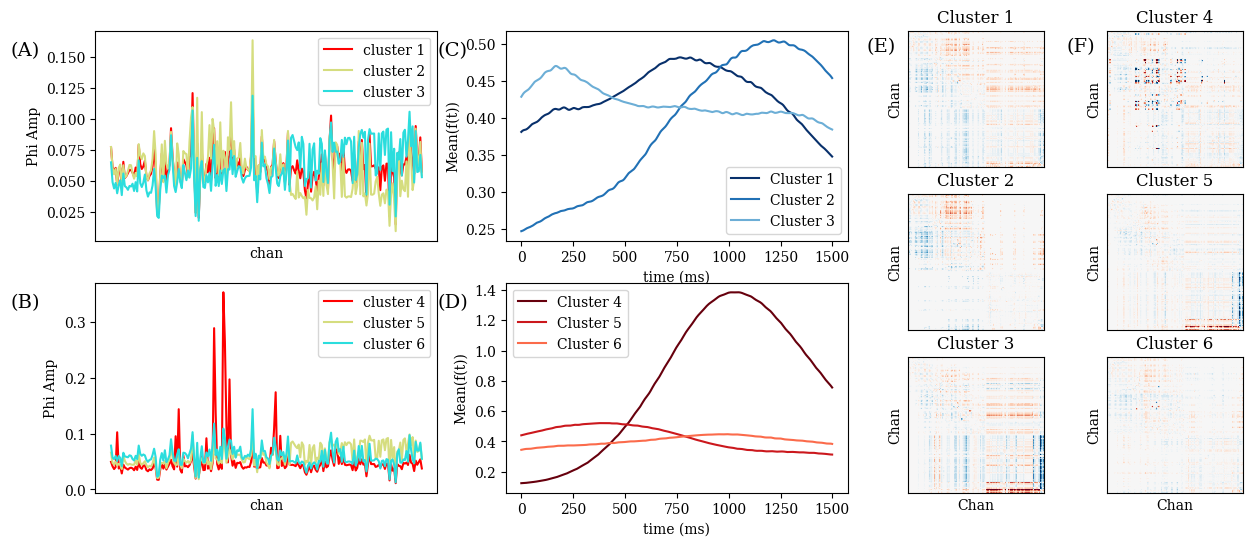

In [35]:
#Plot Figure

plt.rc('font', family='serif')
fig = plt.figure(figsize=(15,6))

#phi amp 1
ax = fig.add_subplot(231)
ax.set_xticks([])
for i in range(len(np.unique(labels_cor))):
    temp = np.mean(phi_a_cor[labels_cor==i], axis=0)

    ax.plot(
        temp, 
        color=cm.rainbow_r((i)/(len(np.unique(labels_cor)))), 
        label='cluster '+str(i+1)
    )
ax.legend()
ax.set_xlabel('chan')
ax.set_ylabel('Phi Amp')
ax.text(-0.25, 0.95, '(A)', transform=ax.transAxes, fontsize=14, verticalalignment='top')

#phi amp 2
ax = fig.add_subplot(234)
ax.set_xticks([])
for i in range(len(np.unique(labels_inc))):
    temp = np.mean(phi_a_inc[labels_inc==i], axis=0)

    ax.plot(
        temp, 
        color=cm.rainbow_r((i)/(len(np.unique(labels_inc)))), 
        label='cluster '+str(i+1+3)
    )
ax.legend()
ax.set_xlabel('chan')
ax.set_ylabel('Phi Amp')
ax.text(-0.25, 0.95, '(B)', transform=ax.transAxes, fontsize=14, verticalalignment='top')

#f(t) 1
ax = fig.add_subplot(232)
for i in range(len(np.unique(labels_cor))):
    ax.plot(np.mean(f_cor[labels_cor==i], axis=0), \
            color=cm.Blues_r((i)/(len(np.unique(labels_cor))+1)), label='Cluster '+str(i+1))
    
ax.legend()
ax.set_xlabel('time (ms)')
ax.set_ylabel('Mean(f(t))')
ax.text(-0.20, 0.95, '(C)', transform=ax.transAxes, fontsize=14, verticalalignment='top')

#f(t) 2
ax = fig.add_subplot(235)
for i in range(len(np.unique(labels_inc))):
    ax.plot(np.mean(f_inc[labels_inc==i], axis=0), \
            color=cm.Reds_r((i)/(len(np.unique(labels_inc))+1)), \
            label='Cluster '+str(i+1+len(np.unique(labels_cor))))
    
ax.legend()
ax.set_xlabel('time (ms)')
ax.set_ylabel('Mean(f(t))')
ax.text(-0.20, 0.95, '(D)', transform=ax.transAxes, fontsize=14, verticalalignment='top')

#phase correct
for i in range(3):
    ax = fig.add_subplot(3,6,5+i*6)
    ax.set_xticks([])
    ax.set_yticks([])
    temp_pa, temp_pp = get_phase_vec_avg(
        phase_cor[labels_cor==i]
    )
    temp_pp[temp_pa<0.4]=0
    
    ax.tick_params(axis='both',which='both',direction='in',right=True,top=True)
    if i==0 or i==1:
        ax.set_xticklabels([])
    ax.imshow(temp_pp, aspect='equal', cmap='RdBu', vmin=-np.pi/4, vmax=np.pi/4)
    ax.set_title('Cluster '+str(i+1))
    ax.set_ylabel('Chan')
    if i==2:
        ax.set_xlabel('Chan')
    if i==0:
        ax.text(-0.30, 0.95, '(E)', transform=ax.transAxes, fontsize=14, verticalalignment='top')
    
#phase incorrect
for i in range(3):
    ax = fig.add_subplot(3,6,6+i*6)
    ax.set_xticks([])
    ax.set_yticks([])
    temp_pa, temp_pp = get_phase_vec_avg(
        phase_inc[labels_inc==i]
    )
    temp_pp[temp_pa<0.4]=0
    
    ax.tick_params(axis='both',which='both',direction='in',right=True,top=True)
    if i==0 or i==1:
        ax.set_xticklabels([])
    ax.imshow(temp_pp, aspect='equal', cmap='RdBu', vmin=-np.pi/4, vmax=np.pi/4)
    ax.set_title('Cluster '+str(i+1+3))
    ax.set_ylabel('Chan')
    if i==2:
        ax.set_xlabel('Chan')
    if i==0:
        ax.text(-0.30, 0.95, '(F)', transform=ax.transAxes, fontsize=14, verticalalignment='top')

# plt.savefig('/nas_data/john_scratch/novel_all.svg', bbox_inches='tight')

plt.show()

In [36]:
labels_cor2 = []
labels_inc2 = []

for i in range(3):
    km_cor2 = KMeans(n_clusters=3, n_init='auto', random_state=0)
    km_cor2 = km_cor2.fit(phi_a_cor[labels_cor==i])
    labels_cor2.append(km_cor2.labels_)

    km_inc2 = KMeans(n_clusters=3, n_init='auto', random_state=0)
    km_inc2 = km_inc2.fit(phi_a_inc[labels_inc==i])
    labels_inc2.append(km_inc2.labels_)

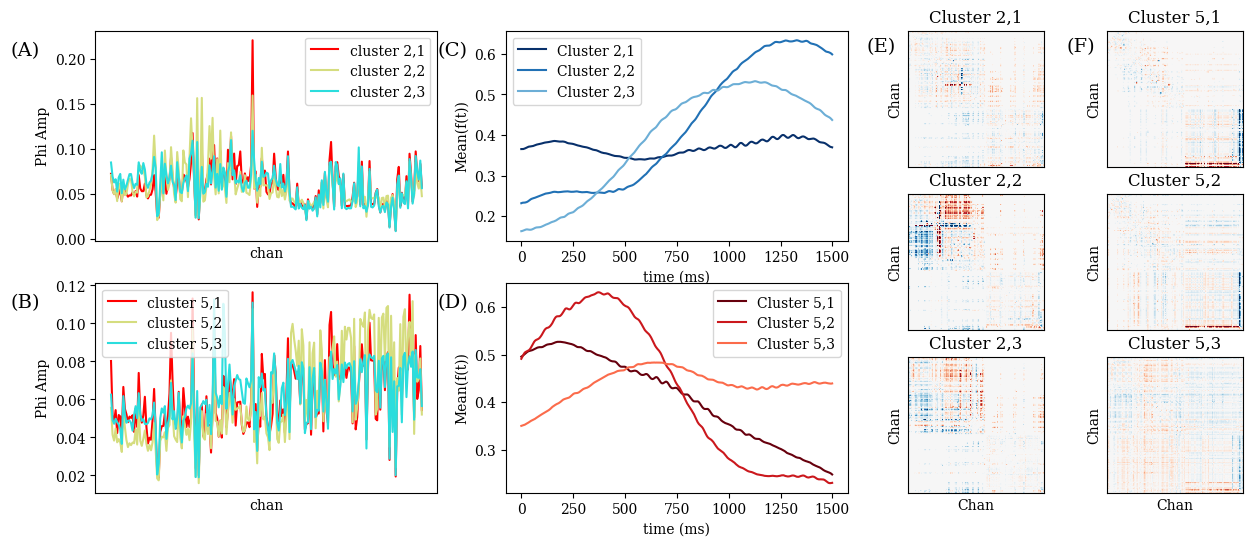

In [39]:
first_label_idx = 1

#Plot Figure

plt.rc('font', family='serif')
fig = plt.figure(figsize=(15,6))

#phi amp 1
ax = fig.add_subplot(231)
ax.set_xticks([])
for i in range(len(np.unique(labels_cor))):
    temp = np.mean(phi_a_cor[labels_cor==first_label_idx][labels_cor2[first_label_idx]==i], axis=0)

    ax.plot(
        temp, 
        color=cm.rainbow_r((i)/(len(np.unique(labels_cor)))), 
        label='cluster '+str(first_label_idx+1)+','+str(i+1)
    )
ax.legend()
ax.set_xlabel('chan')
ax.set_ylabel('Phi Amp')
ax.text(-0.25, 0.95, '(A)', transform=ax.transAxes, fontsize=14, verticalalignment='top')

#phi amp 2
ax = fig.add_subplot(234)
ax.set_xticks([])
for i in range(len(np.unique(labels_inc))):
    temp = np.mean(phi_a_inc[labels_inc==first_label_idx][labels_inc2[first_label_idx]==i], axis=0)

    ax.plot(
        temp, 
        color=cm.rainbow_r((i)/(len(np.unique(labels_inc)))), 
        label='cluster '+str(first_label_idx+1+3)+','+str(i+1)
    )
ax.legend()
ax.set_xlabel('chan')
ax.set_ylabel('Phi Amp')
ax.text(-0.25, 0.95, '(B)', transform=ax.transAxes, fontsize=14, verticalalignment='top')

#f(t) 1
ax = fig.add_subplot(232)
for i in range(len(np.unique(labels_cor))):
    ax.plot(np.mean(f_cor[labels_cor==first_label_idx][labels_cor2[first_label_idx]==i], axis=0), \
            color=cm.Blues_r((i)/(len(np.unique(labels_cor))+1)), label='Cluster '+str(first_label_idx+1)+','+str(i+1))
    
ax.legend()
ax.set_xlabel('time (ms)')
ax.set_ylabel('Mean(f(t))')
ax.text(-0.20, 0.95, '(C)', transform=ax.transAxes, fontsize=14, verticalalignment='top')

#f(t) 2
ax = fig.add_subplot(235)
for i in range(len(np.unique(labels_inc))):
    ax.plot(np.mean(f_inc[labels_inc==first_label_idx][labels_inc2[first_label_idx]==i], axis=0), \
            color=cm.Reds_r((i)/(len(np.unique(labels_inc))+1)), \
            label='Cluster '+str(first_label_idx+1+len(np.unique(labels_cor)))+','+str(i+1))
    
ax.legend()
ax.set_xlabel('time (ms)')
ax.set_ylabel('Mean(f(t))')
ax.text(-0.20, 0.95, '(D)', transform=ax.transAxes, fontsize=14, verticalalignment='top')

#phase correct
for i in range(3):
    ax = fig.add_subplot(3,6,5+i*6)
    ax.set_xticks([])
    ax.set_yticks([])
    temp_pa, temp_pp = get_phase_vec_avg(
        phase_cor[labels_cor==first_label_idx][labels_cor2[first_label_idx]==i]
    )
    temp_pp[temp_pa<0.4]=0
    
    ax.tick_params(axis='both',which='both',direction='in',right=True,top=True)
    if i==0 or i==1:
        ax.set_xticklabels([])
    ax.imshow(temp_pp, aspect='equal', cmap='RdBu', vmin=-np.pi/4, vmax=np.pi/4)
    ax.set_title('Cluster '+str(first_label_idx+1)+','+str(i+1))
    ax.set_ylabel('Chan')
    if i==2:
        ax.set_xlabel('Chan')
    if i==0:
        ax.text(-0.30, 0.95, '(E)', transform=ax.transAxes, fontsize=14, verticalalignment='top')
    
#phase incorrect
for i in range(3):
    ax = fig.add_subplot(3,6,6+i*6)
    ax.set_xticks([])
    ax.set_yticks([])
    temp_pa, temp_pp = get_phase_vec_avg(
        phase_inc[labels_inc==first_label_idx][labels_inc2[first_label_idx]==i]
    )
    temp_pp[temp_pa<0.4]=0
    
    ax.tick_params(axis='both',which='both',direction='in',right=True,top=True)
    if i==0 or i==1:
        ax.set_xticklabels([])
    ax.imshow(temp_pp, aspect='equal', cmap='RdBu', vmin=-np.pi/4, vmax=np.pi/4)
    ax.set_title('Cluster '+str(first_label_idx+1+3)+','+str(i+1))
    ax.set_ylabel('Chan')
    if i==2:
        ax.set_xlabel('Chan')
    if i==0:
        ax.text(-0.30, 0.95, '(F)', transform=ax.transAxes, fontsize=14, verticalalignment='top')

# plt.savefig('/nas_data/john_scratch/novel_all.svg', bbox_inches='tight')

plt.show()

In [40]:
plt.rcParams.update({'font.size': 12})

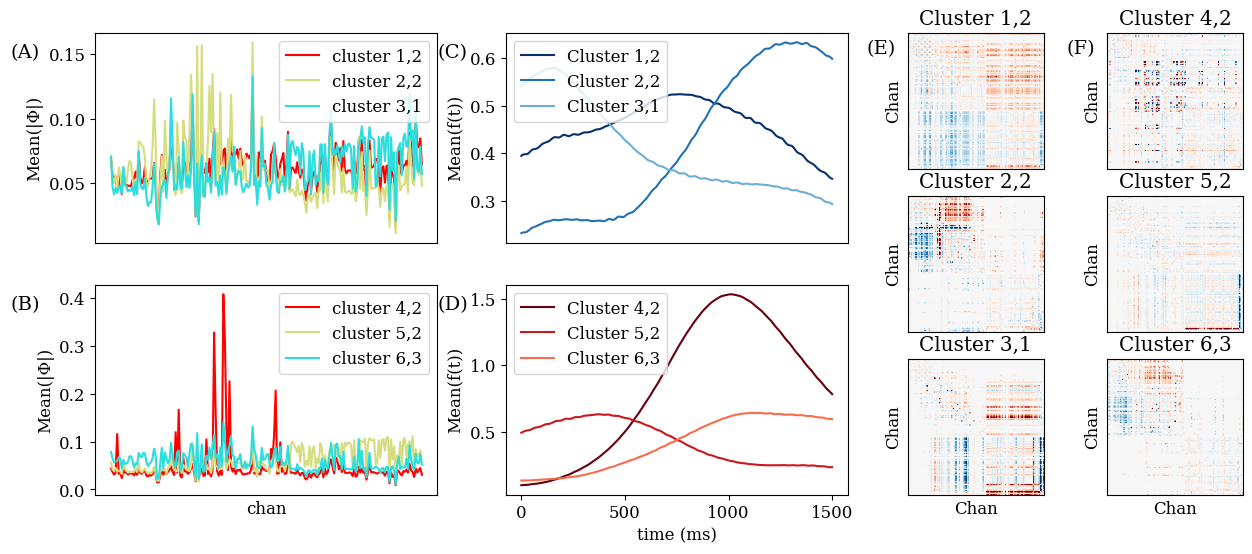

In [44]:
cluster_cor = np.array([[0,1], [1,1], [2,0]])
cluster_inc = np.array([[0,1], [1,1], [2,2]])

first_label_idx = 2

#Plot Figure

plt.rc('font', family='serif')
fig = plt.figure(figsize=(15,6))

#phi amp 1
ax = fig.add_subplot(231)
ax.set_xticks([])
for i in range(len(np.unique(labels_cor))):
    temp = np.mean(phi_a_cor[labels_cor==cluster_cor[i,0]][labels_cor2[cluster_cor[i,0]]==cluster_cor[i,1]], axis=0)

    ax.plot(
        temp, 
        color=cm.rainbow_r((i)/(len(np.unique(labels_cor)))), 
        label='cluster '+str(cluster_cor[i,0]+1)+','+str(cluster_cor[i,1]+1)
    )
ax.legend()
ax.set_ylabel('Mean(|Φ|)')
ax.text(-0.25, 0.95, '(A)', transform=ax.transAxes, fontsize=14, verticalalignment='top')

#phi amp 2
ax = fig.add_subplot(234)
ax.set_xticks([])
for i in range(len(np.unique(labels_inc))):
    temp = np.mean(phi_a_inc[labels_inc==cluster_inc[i,0]][labels_inc2[cluster_inc[i,0]]==cluster_inc[i,1]], axis=0)

    ax.plot(
        temp, 
        color=cm.rainbow_r((i)/(len(np.unique(labels_inc)))), 
        label='cluster '+str(cluster_inc[i,0]+1+3)+','+str(cluster_inc[i,1]+1)
    )
ax.legend()
ax.set_xlabel('chan')
ax.set_ylabel('Mean(|Φ|)')
ax.text(-0.25, 0.95, '(B)', transform=ax.transAxes, fontsize=14, verticalalignment='top')

#f(t) 1
ax = fig.add_subplot(232)
for i in range(len(np.unique(labels_cor))):
    ax.plot(np.mean(f_cor[labels_cor==cluster_cor[i,0]][labels_cor2[cluster_cor[i,0]]==cluster_cor[i,1]], axis=0), \
            color=cm.Blues_r((i)/(len(np.unique(labels_cor))+1)), label='Cluster '+str(cluster_cor[i,0]+1)+','+str(cluster_cor[i,1]+1))
    
ax.legend()
ax.set_xticks([])
ax.set_ylabel('Mean(f(t))')
ax.text(-0.20, 0.95, '(C)', transform=ax.transAxes, fontsize=14, verticalalignment='top')

#f(t) 2
ax = fig.add_subplot(235)
for i in range(len(np.unique(labels_inc))):
    ax.plot(np.mean(f_inc[labels_inc==cluster_inc[i,0]][labels_inc2[cluster_inc[i,0]]==cluster_inc[i,1]], axis=0), \
            color=cm.Reds_r((i)/(len(np.unique(labels_inc))+1)), \
            label='Cluster '+str(cluster_inc[i,0]+1+len(np.unique(labels_cor)))+','+str(cluster_inc[i,1]+1))
    
ax.legend()
ax.set_xlabel('time (ms)')
ax.set_ylabel('Mean(f(t))')
ax.text(-0.20, 0.95, '(D)', transform=ax.transAxes, fontsize=14, verticalalignment='top')

#phase correct
for i in range(3):
    ax = fig.add_subplot(3,6,5+i*6)
    ax.set_xticks([])
    ax.set_yticks([])
    temp_pa, temp_pp = get_phase_vec_avg(
        phase_cor[labels_cor==cluster_cor[i,0]][labels_cor2[cluster_cor[i,0]]==cluster_cor[i,1]]
    )
    temp_pp[temp_pa<0.4]=0
    
    ax.tick_params(axis='both',which='both',direction='in',right=True,top=True)
    if i==0 or i==1:
        ax.set_xticklabels([])
    ax.imshow(temp_pp, aspect='equal', cmap='RdBu', vmin=-np.pi/4, vmax=np.pi/4)
    ax.set_title('Cluster '+str(cluster_cor[i,0]+1)+','+str(cluster_cor[i,1]+1))
    ax.set_ylabel('Chan')
    if i==2:
        ax.set_xlabel('Chan')
    if i==0:
        ax.text(-0.30, 0.95, '(E)', transform=ax.transAxes, fontsize=14, verticalalignment='top')
    
#phase incorrect
for i in range(3):
    ax = fig.add_subplot(3,6,6+i*6)
    ax.set_xticks([])
    ax.set_yticks([])
    temp_pa, temp_pp = get_phase_vec_avg(
        phase_inc[labels_inc==cluster_inc[i,0]][labels_inc2[cluster_inc[i,0]]==cluster_inc[i,1]]
    )
    temp_pp[temp_pa<0.4]=0
    
    ax.tick_params(axis='both',which='both',direction='in',right=True,top=True)
    if i==0 or i==1:
        ax.set_xticklabels([])
    ax.imshow(temp_pp, aspect='equal', cmap='RdBu', vmin=-np.pi/4, vmax=np.pi/4)
    ax.set_title('Cluster '+str(cluster_inc[i,0]+1+3)+','+str(cluster_inc[i,1]+1))
    ax.set_ylabel('Chan')
    if i==2:
        ax.set_xlabel('Chan')
    if i==0:
        ax.text(-0.30, 0.95, '(F)', transform=ax.transAxes, fontsize=14, verticalalignment='top')

# plt.savefig('/nas_data/john_scratch/novel_all.svg', bbox_inches='tight')

plt.show()

In [45]:
for i,j in cluster_cor:
    print(np.sum(labels_cor2[i]==j))

for i,j in cluster_inc:
    print(np.sum(labels_inc2[i]==j))

226
76
151
86
88
77


## Comparing to Standard Analysis

In [13]:
f_power = np.hstack([np.mean(f, axis=1) for f in f_hat])
freq_m = np.hstack(freq)

Text(0, 0.5, 'Mean f(t) Amp')

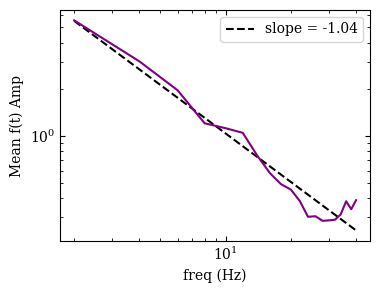

In [14]:
plt.rc('font', family='serif')

fig = plt.figure(figsize=(4, 3))
ax = fig.add_subplot(1, 1, 1)
ax.tick_params(axis='both',which='both',direction='in',right=True,top=True)

bin_edges = np.arange(1,42,2)
bins = []
for j in range(len(bin_edges)-1):
    bins.append([])
for i in range(len(np.hstack(freq))):
    for j in range(len(bin_edges)-1):
        idx = (freq_m[i] >= bin_edges[j]) & (freq_m[i] < bin_edges[j+1])
        bins[j].append(f_power[i][idx])
bins_mean = np.empty((len(bins)))
for i in range(len(bins)):
    bins_mean[i] = np.mean(np.hstack(bins[i]))

slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(
    np.log(analysis.moving_average_dim(bin_edges, 2, 0)),
    np.log(bins_mean)
)
xn_power_law = analysis.moving_average_dim(bin_edges, 2, 0)
yn_power_law = np.exp(intercept)*(analysis.moving_average_dim(bin_edges, 2, 0)**slope)
n_power_law_slope = slope
ax.plot(xn_power_law, \
        yn_power_law, \
        color='black', linestyle='dashed', \
        label='slope = '+str(np.round(n_power_law_slope,2)))
ax.legend()

xn_power_law2 = analysis.moving_average_dim(bin_edges, 2, 0)
yn_power_law2 = bins_mean
ax.loglog(xn_power_law2, yn_power_law2, color='purple')
ax.set_xlabel('freq (Hz)')
ax.set_ylabel('Mean f(t) Amp')

In [15]:
y_power_law = []

for d in data:
    x_power_law, temp = ss.welch(d, 1000)
    y_power_law.append(temp)

y_power_law = np.array(y_power_law)
y_power_law = np.mean(y_power_law, axis=0)

slopes = []
intercepts = []
for power in y_power_law:
    slope, intercept, _, _, _ = scipy.stats.linregress(np.log(x_power_law[1:11]), np.log(power[1:11]**0.5))
    slopes.append(slope)
    intercepts.append(intercept)

slope_m = np.mean(slopes)
intercept_m = np.mean(intercepts)

Text(0, 0.5, 'Amp (V*Hz^-0.5)')

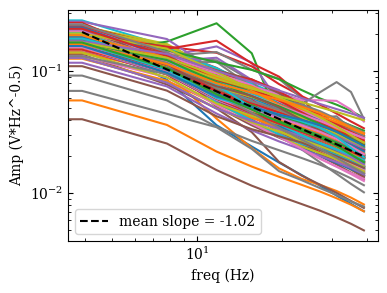

In [16]:
plt.rc('font', family='serif')

fig = plt.figure(figsize=(4, 3))
ax = fig.add_subplot(1, 1, 1)
ax.tick_params(axis='both',which='both',direction='in',right=True,top=True)

x_power_law = x_power_law[:11]
y_power_law = y_power_law[:,:11]

for power in y_power_law:
    ax.loglog(x_power_law, power**0.5)
    
x_power_law2 = x_power_law[1:11]
y_power_law2 = np.exp(intercept_m)*(x_power_law[1:11]**slope_m)
power_law2_slope = slope_m
    
ax.loglog(x_power_law2, \
          y_power_law2, \
          color='black', linestyle='dashed', \
          label='mean slope = '+str(np.round(power_law2_slope,2)))
ax.legend()
ax.set_xlabel('freq (Hz)')
ax.set_ylabel('Amp (V*Hz^-0.5)')

### Hilb Power Compare

In [17]:
sig = np.empty((len(data), len(data[0]), 1500))
for i in range(len(data)):
    t_start = 0
    t_end = 1500
    for j in range(len(data[i])):
        temp_h = analysis.butter_pass_filter(data[i][j], 27, 1000, 'high')
        temp_b = analysis.butter_pass_filter(temp_h, 37, 1000, 'low')
        temp_hilb = ss.hilbert(temp_b)
        sig[i,j] = np.abs(temp_hilb)[t_start+1000:t_end+1000]

In [18]:
sig_r = np.reshape(np.transpose(sig, (1,0,2)), (sig.shape[1], -1))

In [19]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)

sig_t = pca.fit_transform(sig_r.T)
sig_t = sig_t.T.reshape((2,-1,sig.shape[2]))

Text(0, 0.5, 'Mode 0 Amplitude')

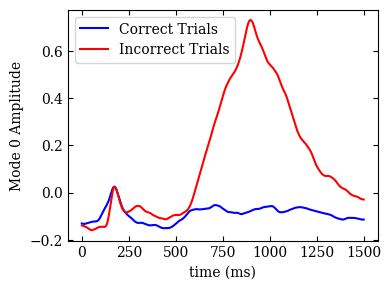

In [20]:
plt.rc('font', family='serif')

fig = plt.figure(figsize=(4, 3))
ax = fig.add_subplot(1, 1, 1)
ax.tick_params(axis='both',which='both',direction='in',right=True,top=True)

x_hilb_cor = np.arange(1500)
x_hilb_inc = np.arange(1500)
y_hilb_cor = np.mean(sig_t[0][res==200],axis=0)
y_hilb_inc = np.mean(sig_t[0][res==206],axis=0)

ax.plot(x_hilb_cor, y_hilb_cor, color='blue', label='Correct Trials')
ax.plot(x_hilb_inc, y_hilb_inc, color='red', label='Incorrect Trials')
ax.legend()
ax.set_xlabel('time (ms)')
ax.set_ylabel('Mode 0 Amplitude')

In [21]:
f_cor = []
f_inc = []
cos_dist = []
thresh = 0

for i in range(len(freq)):
    idx_freq = (freq[i]>27) & (freq[i]<37)
    t_start = 0
    t_end = 1500
    idx_f = np.any(f_hat[i][:,t_start:t_end] > np.mean(f_hat[i], axis=1)[:,None], axis=1)

    cos_dist.append(np.max([utils.cos_dist(p,pca.components_[0]) for p in phi_a[i][idx_freq & idx_f]]))

    if np.max([utils.cos_dist(p,pca.components_[0]) for p in phi_a[i][idx_freq & idx_f]])>thresh:
        if res[i]==200:
            f_cor.append(f_hat[i][idx_freq & idx_f,t_start:t_end])
        else:
            f_inc.append(f_hat[i][idx_freq & idx_f,t_start:t_end])

f_cor = np.vstack(f_cor)
f_inc = np.vstack(f_inc)

Text(0, 0.5, 'mean f(t)')

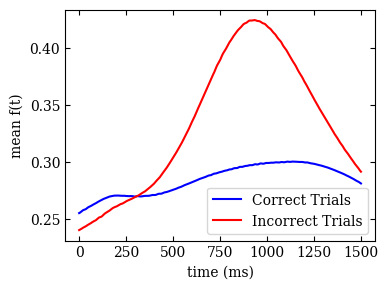

In [22]:
plt.rc('font', family='serif')

fig = plt.figure(figsize=(4, 3))
ax = fig.add_subplot(1, 1, 1)
ax.tick_params(axis='both',which='both',direction='in',right=True,top=True)

yn_hilb_cor = np.mean(f_cor, axis=0)
yn_hilb_inc = np.mean(f_inc, axis=0)
    
ax.plot(yn_hilb_cor, color='b', label='Correct Trials')
ax.plot(yn_hilb_inc, color='r', label='Incorrect Trials')
ax.legend()
ax.set_xlabel('time (ms)')
ax.set_ylabel('mean f(t)')

### Phase Lock

In [23]:
w_ranges = np.array([[i,i+100] for i in range(0,1500-99,100)])
yw_extent = np.mean(w_ranges, axis=1)

temp_phi = [[] for w in w_ranges]

for i in range(len(freq)):
    idx_freq = (freq[i]>2) & (freq[i]<4)
    t_start = 0
    t_end = 1500
    for j,w in enumerate(w_ranges):
        idx_f = np.any(f_hat[i][idx_freq,w[0]:w[1]] > np.mean(f_hat[i][idx_freq], axis=1)[:,None], axis=1)
        temp_phi[j].append(phi_p_single[i][idx_f,40,j])

temp_phi = [np.hstack(temp_phi[i]) for i in range(len(temp_phi))]

In [24]:
ns_phase = []

for i in range(len(temp_phi)):
    c, _ = np.histogram(temp_phi[i], bins=20, range=[-np.pi, np.pi], density=True)
    ns_phase.append(c)
ns_phase = np.array(ns_phase)

Text(0, 0.5, 'phase')

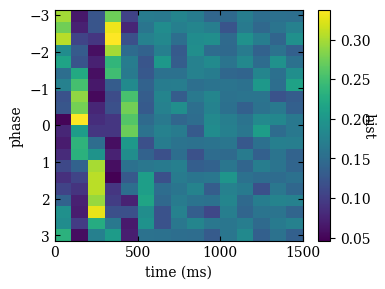

In [25]:
plt.rc('font', family='serif')

fig = plt.figure(figsize=(4, 3))
ax = fig.add_subplot(1, 1, 1)
ax.tick_params(axis='both',which='both',direction='in',right=True,top=True)

yn_phase_lock = ns_phase.T

cax = ax.imshow(yn_phase_lock, aspect='auto', extent=[0,1500,np.pi,-np.pi])
cbar = fig.colorbar(cax)
cbar.set_label('hist', rotation=270)
ax.set_xlabel('time (ms)')
ax.set_ylabel('phase')

In [26]:
sig = np.empty((len(data), 1500))
for i in range(len(data)):
    t_start = 0
    t_end = 1500
    temp_h = analysis.butter_pass_filter(data[i][40], 2, 1000, 'high')
    temp_b = analysis.butter_pass_filter(temp_h, 4, 1000, 'low')
    temp_hilb = ss.hilbert(temp_b)
    sig[i] = np.angle(temp_hilb)[t_start+1000:t_end+1000]

In [27]:
hist_all = []

for i in range(sig.shape[1]):
    c, _ = np.histogram(sig[:,i], bins=20, range=[-np.pi, np.pi], density=True)
    hist_all.append(c)
hist_all = np.array(hist_all)

Text(0, 0.5, 'phase')

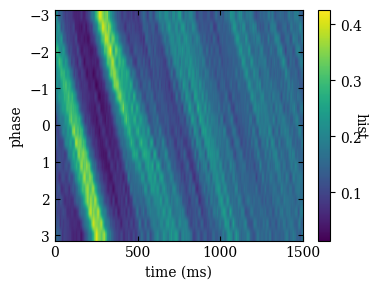

In [28]:
plt.rc('font', family='serif')

fig = plt.figure(figsize=(4, 3))
ax = fig.add_subplot(1, 1, 1)
ax.tick_params(axis='both',which='both',direction='in',right=True,top=True)

y_phase_lock = hist_all.T

cax = ax.imshow(y_phase_lock, aspect='auto', extent=[0,1500,np.pi,-np.pi])
cbar = fig.colorbar(cax)
cbar.set_label('hist', rotation=270)
ax.set_xlabel('time (ms)')
ax.set_ylabel('phase')

### Coherence

In [29]:
def get_phase_vec_avg(phase):
    '''
    Gets the average vector from a list of phases
    
    Parameters
    ---------------
    phase : list of phases where the size of the first dimension matches the length of amps
    
    Returns
    ---------------
    vec_amp : final addition of amplitudes corresponding to any extra dimension in phase
    vec_phase : final phases corresponding to any extra dim in phase
    '''
    vecs = np.sum(np.exp(phase * 1j), axis=0)
    vec_amp = np.abs(vecs) / len(phase)
    vec_phase = np.angle(vecs)
    return(vec_amp, vec_phase)

In [30]:
def avg_phase_every_element(ar):
    '''
    Currently applies to specific case of subtracting axis 1 and then summing over
    '''
    ar_hor = ar[:,:,None] * np.ones(ar.shape[1])[None,None,:]
    ar_ver = ar[:,None,:] * np.ones(ar.shape[1])[None,:,None]
    diff = ar_ver - ar_hor
    pa, pp = get_phase_vec_avg(diff)
    return(pa, pp)

In [31]:
sig = np.empty((len(data), len(data[0]), 500))
for i in range(len(data)):
    t_start = 0
    t_end = 500
    for j in range(len(data[i])):
        sig[i,j] = data[i][j][t_start+1000:t_end+1000]

sig = np.transpose(sig, (1,0,2))

sig = sig[:,res==206]

In [32]:
p1_inc_a = np.ones((sig.shape[0], sig.shape[0]))
p1_inc_p = np.zeros((sig.shape[0], sig.shape[0]))
for i in range(len(sig)):
    print(i)
    for j in range(i+1, len(sig)):
        _, _, p = analysis.coherence(sig[i,:,:], sig[j,:,:], 1000, nperseg=285)
        p1_inc_a[i,j], p1_inc_p[i,j] = get_phase_vec_avg(p[:,1])
        p1_inc_a[j,i] = p1_inc_a[i,j]
        p1_inc_p[j,i] = -p1_inc_p[i,j]

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202


In [33]:
temp_phi = []

for i in range(len(freq)):
    idx_freq = (freq[i]>2) & (freq[i]<4)
    t_start = 0
    t_end = 1500
    idx_f = np.any(f_hat[i][idx_freq,200:400] > np.mean(f_hat[i][idx_freq], axis=1)[:,None], axis=1)
    if res[i]==206:
        temp_phi.append(phi_p_single[i][idx_f,:,2])
        temp_phi.append(phi_p_single[i][idx_f,:,3])

temp_phi = np.vstack(temp_phi)

temp_a_inc, temp_p_inc = avg_phase_every_element(temp_phi)

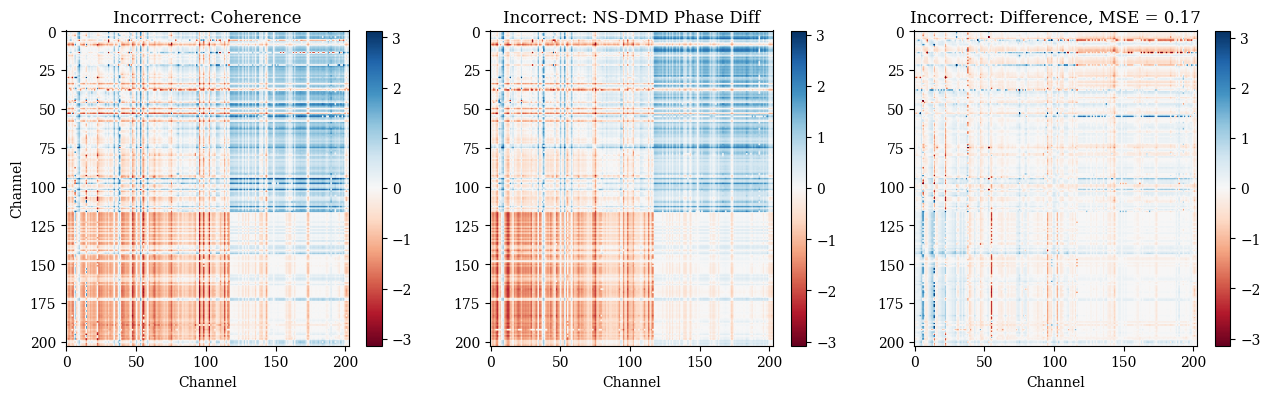

In [34]:
thresh = 0.1

to_plot = temp_p_inc.copy()
to_plot[temp_a_inc < thresh] = 0

to_plot_2 = p1_inc_p.copy()
to_plot_2[p1_inc_a < thresh] = 0

yn_coh = to_plot
y_coh = to_plot_2

maxi=3

fig, ax = plt.subplots(1,maxi,figsize=(13,4))
fig.tight_layout(pad=2)

a0 = ax[0].imshow(to_plot_2, aspect='auto', cmap='RdBu')
cbar = fig.colorbar(a0, ax=ax[0])
ax[0].set_title('Incorrrect: Coherence')
a0 = ax[1].imshow(to_plot, aspect='auto', cmap='RdBu')
cbar = fig.colorbar(a0, ax=ax[1])
ax[1].set_title('Incorrect: NS-DMD Phase Diff')
a0 = ax[2].imshow(to_plot_2 - to_plot, aspect='auto', vmin=-np.pi, vmax=np.pi,\
                  cmap='RdBu')
cbar = fig.colorbar(a0, ax=ax[2])
error = np.round(np.mean((to_plot_2 - to_plot)**2), 2)
ax[2].set_title('Incorrect: Difference, MSE = '+str(error))
ax[0].set_ylabel('Channel')

for i in range(maxi):
    ax[i].set_xlabel('Channel')

### All plots

In [36]:
plt.rcParams.update({'font.size': 12})

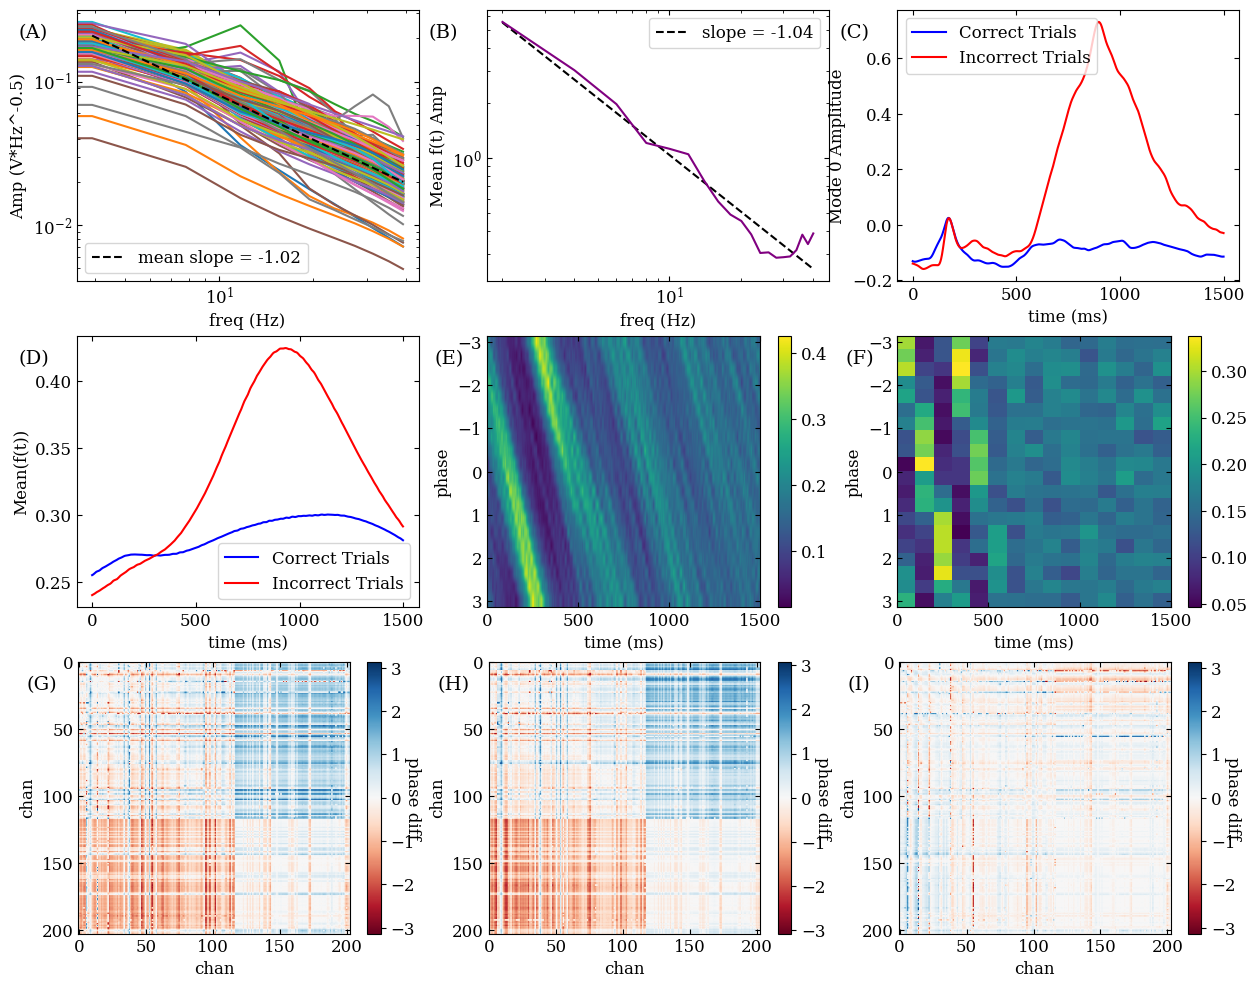

In [43]:
#Plot Figure

plt.rc('font', family='serif')
fig = plt.figure(figsize=(15,12))

#power law real
ax = fig.add_subplot(331)
ax.tick_params(axis='both',which='both',direction='in',right=True,top=True)
plt.rc('font', family='serif')

for power in y_power_law:
    ax.loglog(x_power_law, power[:11]**0.5)
    
ax.loglog(x_power_law2, \
          y_power_law2, \
          color='black', linestyle='dashed', \
          label='mean slope = '+str(np.round(power_law2_slope,2)))
ax.legend()
ax.set_xlabel('freq (Hz)')
ax.set_ylabel('Amp (V*Hz^-0.5)')
ax.text(-0.17, 0.95, '(A)', transform=ax.transAxes, fontsize=14, verticalalignment='top')

#power law nsdmd
ax = fig.add_subplot(332)
ax.tick_params(axis='both',which='both',direction='in',right=True,top=True)
plt.rc('font', family='serif')

ax.plot(xn_power_law, \
        yn_power_law, \
        color='black', linestyle='dashed', \
        label='slope = '+str(np.round(n_power_law_slope,2)))
ax.legend()

ax.loglog(xn_power_law2, yn_power_law2, color='purple')
ax.set_xlabel('freq (Hz)')
ax.set_ylabel('Mean f(t) Amp')
ax.text(-0.17, 0.95, '(B)', transform=ax.transAxes, fontsize=14, verticalalignment='top')

#Hilbert PCA
ax = fig.add_subplot(333)
ax.tick_params(axis='both',which='both',direction='in',right=True,top=True)
plt.rc('font', family='serif')

ax.plot(x_hilb_cor, y_hilb_cor, color='blue', label='Correct Trials')
ax.plot(x_hilb_inc, y_hilb_inc, color='red', label='Incorrect Trials')
ax.legend()
ax.set_xlabel('time (ms)')
ax.set_ylabel('Mode 0 Amplitude')
ax.text(-0.17, 0.95, '(C)', transform=ax.transAxes, fontsize=14, verticalalignment='top')

#Hilbert NSDMD
ax = fig.add_subplot(334)
ax.tick_params(axis='both',which='both',direction='in',right=True,top=True)
plt.rc('font', family='serif')

ax.plot(yn_hilb_cor, color='b', label='Correct Trials')
ax.plot(yn_hilb_inc, color='r', label='Incorrect Trials')
ax.legend()
ax.set_xlabel('time (ms)')
ax.set_ylabel('Mean(f(t))')
ax.text(-0.17, 0.95, '(D)', transform=ax.transAxes, fontsize=14, verticalalignment='top')

#Phase Lock
ax = fig.add_subplot(335)
ax.tick_params(axis='both',which='both',direction='in',right=True,top=True)
plt.rc('font', family='serif')

cax = ax.imshow(y_phase_lock, aspect='auto', extent=[0,1500,np.pi,-np.pi])
cbar = fig.colorbar(cax)
ax.set_xlabel('time (ms)')
ax.set_ylabel('phase')
ax.text(-0.19, 0.95, '(E)', transform=ax.transAxes, fontsize=14, verticalalignment='top')

#Phase Lock NSDMD
ax = fig.add_subplot(336)
ax.tick_params(axis='both',which='both',direction='in',right=True,top=True)
plt.rc('font', family='serif')

cax = ax.imshow(yn_phase_lock, aspect='auto', extent=[0,1500,np.pi,-np.pi])
cbar = fig.colorbar(cax)
ax.set_xlabel('time (ms)')
ax.set_ylabel('phase')
ax.text(-0.19, 0.95, '(F)', transform=ax.transAxes, fontsize=14, verticalalignment='top')

#Coherence
ax = fig.add_subplot(337)
ax.tick_params(axis='both',which='both',direction='in',right=True,top=True)
plt.rc('font', family='serif')

cax = ax.imshow(y_coh, aspect='equal', cmap='RdBu')
cbar = fig.colorbar(cax)
cbar.set_label('phase diff', rotation=270)
ax.set_xlabel('chan')
ax.set_ylabel('chan')
ax.text(-0.19, 0.95, '(G)', transform=ax.transAxes, fontsize=14, verticalalignment='top')

#Coherence NSDMD
ax = fig.add_subplot(338)
ax.tick_params(axis='both',which='both',direction='in',right=True,top=True)
plt.rc('font', family='serif')

cax = ax.imshow(yn_coh, aspect='equal', cmap='RdBu')
cbar = fig.colorbar(cax)
cbar.set_label('phase diff', rotation=270)
ax.set_xlabel('chan')
ax.set_ylabel('chan')
ax.text(-0.19, 0.95, '(H)', transform=ax.transAxes, fontsize=14, verticalalignment='top')

#Coherence NSDMD
ax = fig.add_subplot(339)
ax.tick_params(axis='both',which='both',direction='in',right=True,top=True)
plt.rc('font', family='serif')

cax = ax.imshow((y_coh - yn_coh + np.pi) % (2*np.pi) - np.pi, aspect='equal', cmap='RdBu')
cbar = fig.colorbar(cax)
cbar.set_label('phase diff', rotation=270)
ax.set_xlabel('chan')
ax.set_ylabel('chan')
ax.text(-0.19, 0.95, '(I)', transform=ax.transAxes, fontsize=14, verticalalignment='top')

# plt.savefig('/nas_data/john_scratch/real_comparison_all.svg', bbox_inches='tight')

plt.show()